### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import scipy.stats
from scipy import interpolate
from scipy.special import expit, logit, logsumexp 
from scipy.optimize import minimize, minimize_scalar, brentq

In [3]:
from IPython import embed

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [4]:
import os
import re
import sys

In [5]:
import sys
sys.path += ["../../", "../", "../../../"]
from expected_cost import ec, utils

In [6]:
from psrcal.calibration import *

## Funciones

In [7]:
def cross_entropy(pos, neg, pos_prior=0.5, deriv=False):
    baseline = -pos_prior * np.log(pos_prior) - (1 - pos_prior) * np.log(1 - pos_prior)
    logitprior = logit(pos_prior)
    if not deriv:
        pos = np.mean(softplus(-pos - logitprior))
        neg = np.mean(softplus(neg + logitprior))
        return (pos_prior * pos + (1 - pos_prior) * neg) / baseline

    pos, back1 = softplus(- pos - logitprior, deriv=True)
    neg, back2 = softplus(neg + logitprior, deriv=True)
    k1 = pos_prior / (len(pos) * baseline)
    k2 = (1 - pos_prior) / (len(neg) * baseline)
    y = k1 * pos.sum() + k2 * neg.sum()

    def back(dy):
        dtar = back1(-dy * k1)
        dnon = back2(dy * k2)
        return dtar, dnon

    return y, back

def cs_softplus(x):
    """numerically stable and complex-step-friendly version of:
       softplus = log( 1 + exp(x) )
    """
    if not np.iscomplexobj(x):
        return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
    # return np.log( 1 + np.exp(x) )
    rx = np.real(x)
    y = cs_softplus(rx)
    return y + 1.0j * expit(rx) * np.imag(x)

def cs_sigmoid(x):
    """numerically stable and complex-step-friendly version of sigmoid"""
    if not np.iscomplexobj(x): return expit(x)
    rx = np.real(x)
    p, q = expit(rx), expit(-rx)
    return p + 1.0j * p * q * np.imag(x)

def softplus(x, deriv=False):
    y = cs_softplus(x)
    if not deriv: return y

    dydx = cs_sigmoid(x)

    def back(dy): return dy * dydx

    return y, back

def optobjective(f, trans=None, sign=1.0, **kwargs):
    """Wrapper for f to turn it into a minimization objective.
    The objective is:
        obj(x) = sign*f(*trans(x),**kwargs)
    where f can take multiple inputs and has a scalar output.
    The input x is a vector.
    Both f(...,deriv=True) and trans(...) return backpropagation
    handles, but obj(x) immediately returns value, gradient.
    """
    if not trans is None:
        def obj(x):
            *args, back1 = trans(x, deriv=True)
            y, back2 = f(*args, deriv=True, **kwargs)
            g = back1(*back2(sign))
            return sign * y, g
    else:
        def obj(x):
            y, back2 = f(x, deriv=True, **kwargs)
            g = back2(sign)
            return sign * y, g

    return obj

def trans(a, b, *, x, deriv=False):
    if not deriv:
        return a * x + b

    def back(dy):
        da = dy @ x
        db = dy.sum()
        return da, db

    return a * x + b, back

def obj(params, *, pos_scores, neg_scores, positive_prior=0.5, deriv=False):
    a, b = params
    if not deriv:
        return cross_entropy(trans(a, b, x=pos_scores),
                             trans(a, b, x=neg_scores),
                             pos_prior=positive_prior)
    t, back1 = trans(a, b, x=pos_scores, deriv=True)
    n, back2 = trans(a, b, x=neg_scores, deriv=True)
    y, back3 = cross_entropy(t, n, pos_prior=positive_prior, deriv=True)

    def back(dy):
        dt, dn = back3(dy)
        da, db = back2(dn)
        da2, db2 = back1(dt)
        return np.array([da + da2, db + db2])

    return y, back

In [8]:
def plot_vertical_line(x, ylim, style, label, ax):
    ax.plot([x,x], ylim, style, label=label)

def value_at_thr(values, thrs, sel_thr):
    # Encuentro el valor thrs que está más cerca de sel_thr
    # y luego busco en values el que corresponde
    i = np.argmin(np.abs(np.array(thrs)-sel_thr))
    return values[i]

def get_expected_costs(y_true, y_pred, positive_prior, cost_matrix):
  priors = np.array([1-positive_prior , positive_prior])
  neg_scores = y_pred[y_true==0]
  pos_scores = y_pred[y_true==1]
  N0 = len(neg_scores)
  N1 = len(pos_scores) 
  K = N0 + N1   
  # Cantidad de muestras de la clase 0 con un score mayor al umbral (thr) 
  K01 = np.sum(neg_scores==1)
  # Cantidad de muestras de la clase 1 con un score menor al umbral (thr) 
  K10 = np.sum(pos_scores==0)
  K11 = np.sum(pos_scores==1)
  K00 = np.sum(neg_scores==0)
  assert K01 + K10 + K11 + K00 == K
  assert K01 + K00 == N0
  assert K10 + K11 == N1
  # Este método calcula la tasa de error para cada clase y decisión
  R = utils.compute_R_matrix_from_counts_for_binary_classif(K01, K10, N0, N1)

  # ECA usa las priors en los datos # AHORA NO TIENE LOS PRIORS EN LOS DATOS
  EC = ec.average_cost_from_confusion_matrix(R, priors, ec.CostMatrix(cost_matrix), adjusted=False) #Ojo que con adjusted=True es el NEC
  NEC = ec.average_cost_from_confusion_matrix(R, priors, ec.CostMatrix(cost_matrix), adjusted=True)
  return EC, NEC

def add_EC(dataset, score, datasets, real_prior, cost_matrix, use_calib=False):
  if use_calib:
    scores = datasets[dataset]['after_cal'][score]['LLR']
  else:
    scores = datasets[dataset][score]['LLR']

  thrs = np.arange(scores.min(), scores.max(), (scores.max()-scores.min())/1000) 
  datasets[dataset][score]['thresholds'] = thrs
  EC = np.zeros(len(thrs))
  NEC = np.zeros(len(thrs))
  priors = np.array([1-real_prior , real_prior])
  neg_scores = scores[datasets[dataset]['targets']==0]
  pos_scores = scores[datasets[dataset]['targets']==1]
  N0 = len(neg_scores)
  N1 = len(pos_scores) 
  K = N0 + N1  
  for i,thr in enumerate(thrs):  
    # Cantidad de muestras de la clase 0 con un score mayor al umbral (thr) 
    K01 = np.sum(neg_scores>=thr)
    # Cantidad de muestras de la clase 1 con un score menor al umbral (thr) 
    K10 = np.sum(pos_scores<thr)
    K11 = np.sum(pos_scores>=thr)
    K00 = np.sum(neg_scores<thr)
    assert K01 + K10 + K11 + K00 == K
    assert K01 + K00 == N0
    assert K10 + K11 == N1
    # Este método calcula la tasa de error para cada clase y decisión
    R = utils.compute_R_matrix_from_counts_for_binary_classif(K01, K10, N0, N1)

    # ECA usa las priors en los datos # AHORA NO TIENE LOS PRIORS EN LOS DATOS
    EC[i] = ec.average_cost_from_confusion_matrix(R, priors, ec.CostMatrix(cost_matrix), adjusted=False) #Ojo que con adjusted=True es el NEC
    NEC[i] = ec.average_cost_from_confusion_matrix(R, priors, ec.CostMatrix(cost_matrix), adjusted=True)
  datasets[dataset][score]['EC'] = EC
  datasets[dataset][score]['NEC'] = NEC
  print('Min EC: {:.4f} \nMin NEC: {:.4f} \n Min th (best th)={:.4f}'.format(EC.min(), NEC.min(), thrs[np.nanargmin(NEC)]))

def plot_cost_and_thrs(dataset, score, datasets, real_prior, cost_matrix):
  cost_matrix = ec.CostMatrix(cost_matrix)
  colors = {'EC': 'b', 
            'NEC':'orange'}
  fig, axs = plt.subplots(1,len(colors),figsize=(4*len(colors),3.5))
  priors = np.array([1-real_prior , real_prior])
  
  thrs = datasets[dataset][score]['thresholds'] 
  EC = datasets[dataset][score]['EC'] 
  NEC = datasets[dataset][score]['NEC'] 

  ax_ = 0
  for metric, metric_arr in zip(['EC','NEC'],[EC,NEC]) :
    axs[ax_].plot(thrs, metric_arr, label=metric, color=colors[metric])
    ax_+=1

  datasets[dataset][score]['bayes_thr_for_EC'] = utils.bayes_thr_for_llrs(priors, cost_matrix)
  datasets[dataset][score]['best_thr_for_EC']  = thrs[np.nanargmin(EC)]
  bayes_idx = np.abs(thrs - datasets[dataset][score]['bayes_thr_for_EC']).argmin()

  print('Bayes LLR th={:.4f}\nBayes EC={:.4f}\nBayes NEC={:.4f}'.format(datasets[dataset][score]['bayes_thr_for_EC'],
                                                              EC[bayes_idx],
                                                              NEC[bayes_idx]))
  # Ploteamos los umbrales obtenidos con Bayes (que coinciden con los óptimos en este caso)
  for ax, metric in zip(axs, colors.keys()):
    ylim = ax.get_ylim()    
    plot_vertical_line(datasets[dataset][score]['bayes_thr_for_EC'], ylim, style='c--',label='Bayes', ax=ax) 
    plot_vertical_line(datasets[dataset][score]['best_thr_for_EC'], ylim, style='c-',label='Best', ax=ax) 
    ax.set_xlabel("Threshold")
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')

def binarize_scores(dataset, score, datasets, th_type='bayes'):

  scores = datasets[dataset][score]['LLR']
  th = datasets[dataset][score][f'{th_type}_thr_for_EC']
  print('{} th is LLR={:.4f} LR={:.4f}'.format(th_type, th, np.exp(th)))
  datasets[dataset][score][f'{th_type}_binary'] = (scores > th).astype(int)

  scores = datasets[dataset]['after_cal'][score]['LLR']
  datasets[dataset]['after_cal'][score][f'{th_type}_binary'] = (scores > th).astype(int)

def print_classification_metrics(y_true, y_pred, positive_prior=None, cost_matrix=None):
  metrics = {}
  metrics['binary_CE'] = log_loss(y_true, y_pred)
  metrics['binary_roc_auc'] = roc_auc_score(y_true, y_pred)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  metrics['binary_pr_auc'] = auc(recall,precision)
  metrics['accuracy'] = accuracy_score(y_true, y_pred)
  metrics['precision'] = precision_score(y_true, y_pred)
  metrics['recall'] = recall_score(y_true, y_pred)
  metrics['f1'] = f1_score(y_true, y_pred)
  if positive_prior is not None and cost_matrix is not None:
    metrics['EC'], metrics['NEC'] = get_expected_costs(y_true, y_pred, positive_prior, cost_matrix)
  c = confusion_matrix(y_true, y_pred)
  metrics['specificity'] = c[0][0]/(c[0][1] + c[0][0])
  metrics['vpn'] = c[0][0]/(c[1][0] + c[0][0])

  print('Classification metrics:')
  for key,val in metrics.items():
    print("{}: {:.4f}".format(key,val))
  return metrics

def add_classification_metrics(dataset,score,datasets, use_calib=False, th_type='bayes', positive_prior=None, cost_matrix=None):
  if use_calib:
    y_pred = datasets[dataset]['after_cal'][score][f'{th_type}_binary']
  else:
    y_pred = datasets[dataset][score][f'{th_type}_binary']
  y_true = datasets[dataset]['targets']
  metrics = print_classification_metrics(y_true, y_pred, positive_prior, cost_matrix)
  if use_calib:
    datasets[dataset]['after_cal'][score][f'{th_type}_binary_metrics'] = metrics
  else:
    datasets[dataset][score][f'{th_type}_binary_metrics'] = metrics

def train_logreg(LLRs, targets, weight_with_positive_prior=None):
  """ Train logistic regression with CE. 
  If weight_with_positive_prior is defined, it is used to train with WCE
  """
  if weight_with_positive_prior is not None:
    trobj = optobjective(obj, sign=1.0,
                          pos_scores=LLRs[targets == 1.0],
                          neg_scores=LLRs[targets == 0.0],
                          positive_prior=weight_with_positive_prior)
  else:
    trobj = optobjective(obj, sign=1.0,
                          pos_scores=LLRs[targets == 1.0],
                          neg_scores=LLRs[targets == 0.0])  
  result = minimize(trobj, np.array([1.0, 0.0]), method='L-BFGS-B', jac=True)  
  parameters = [result.x[0], result.x[1]]
  
  return parameters

In [9]:
def calibrate_and_test(dataset, datasets, scores_options, test_size=None, ):
    
  datasets[dataset]['after_cal'] = {}
  n1 = datasets[dataset]['targets'].sum()
  n0 = len(datasets[dataset]['targets'])-n1
  print('n0=', n0, '. n1=', n1, '\n')

  for i, score in enumerate(scores_options):
    # Calibrate
    scores = datasets[dataset][score]['LLR']
    targets = datasets[dataset]['targets']
    idxs = np.arange(len(scores))

    if test_size is not None:
      idx_train, idx_test = train_test_split(idxs, random_state=42, test_size=test_size)
    else:
      # Train with all and test in all:
      idx_train = idxs
      idx_test = idxs

    scores_train = scores[idx_train]
    targets_train = targets[idx_train]
    scores_test = scores[idx_test]
    targets_test = targets[idx_test]    

    # Train logreg
    parameters = train_logreg(scores_train, targets_train, weight_with_positive_prior=datasets[dataset]['weight_prior'])      

    # Save data of regression
    datasets[dataset]['after_cal'][score] = {}
    datasets[dataset]['after_cal'][score]['conf'] = {'reg_parameters': parameters,
                                                     'weight_prior': datasets[dataset]['weight_prior']}

    # Apply calibration to all scores and save 
    calibrated_LLRs = parameters[0] * scores + parameters[1]
    datasets[dataset]['after_cal'][score]['LLR'] = calibrated_LLRs
  
    # Para volver a las posteriors, vuelvo a incorporar la prior de los datos
    datasets[dataset]['after_cal'][score]['posteriors'] = expit(calibrated_LLRs + logit(datasets[dataset]['prior_for_LLRposterior_change']))

    # Calculate cross entropy in test
    orig_ce = log_loss(datasets[dataset]['targets'][idx_test], datasets[dataset][score]['posteriors'][idx_test])
    new_ce = log_loss(datasets[dataset]['targets'][idx_test], datasets[dataset]['after_cal'][score]['posteriors'][idx_test])
    delta_CE = 100 * (orig_ce-new_ce)/orig_ce
    auc = roc_auc_score(datasets[dataset]['targets'], datasets[dataset][score]['LLR'])
    print('-------\n{}\nAUC full data: {:.4f}\nOriginal CE in test: {:.4f}. \nCalibrated CE in test: {:.4f}\nDeltaEPSR in test={:.4f}%\nRegression parameters: [{:.4f}, {:.4f}]\n'.format(score.upper(),auc,
                                                                                                                          orig_ce, new_ce, delta_CE, parameters[0], parameters[1]))

In [10]:
def test_calibrator(calibrator_dataset, tested_dataset, datasets):
    
  datasets[tested_dataset]['after_cal'] = {}
  scores = ['raw_sum', 'lung_normalization']
  n1 = datasets[tested_dataset]['targets'].sum()
  n0 = len(datasets[tested_dataset]['targets'])-n1
  print('n0=', n0, '. n1=', n1)
  for i, score in enumerate(scores):
    parameters = datasets[calibrator_dataset]['after_cal'][score]['conf']['reg_parameters']
    # Apply calibration
    scores = datasets[tested_dataset][score]['LLR']
    calibrated_LLRs = parameters[0] * scores + parameters[1]
    datasets[tested_dataset]['after_cal'][score] = {}
    datasets[tested_dataset]['after_cal'][score]['LLR'] = calibrated_LLRs
  
    # Para volver a las posteriors, vuelvo a incorporar la prior de los datos

    datasets[tested_dataset]['after_cal'][score]['posteriors'] = expit(calibrated_LLRs + logit(datasets[tested_dataset]['prior_for_LLRposterior_change']))

    # Calcular cross entropy
    orig_ce = log_loss(datasets[tested_dataset]['targets'], datasets[tested_dataset][score]['posteriors'])
    new_ce = log_loss(datasets[tested_dataset]['targets'], datasets[tested_dataset]['after_cal'][score]['posteriors'])
    auc = roc_auc_score(datasets[tested_dataset]['targets'], datasets[tested_dataset][score]['LLR'])
    delta_CE = 100 * (orig_ce-new_ce)/orig_ce
    print('-------\n{}\nAUC: {:.4f}\nOriginal CE of {}: {:.4f}. \nCalibrated CE of {}: {:.4f}\nDeltaEPSR={:.4f}%\nRegression parameters: [{:.4f}, {:.4f}]\n'.format(score.upper(), 
                                                                                                                          auc, tested_dataset, orig_ce,  tested_dataset,
                                                                                                                          new_ce, delta_CE, parameters[0], parameters[1]))

In [11]:
def plot_bef_after(dataset_name, score, datasets, type_='LLR', only_positive=False):
  plt.figure()
  c, hs = utils.make_hist(datasets[dataset_name]['targets'], datasets[dataset_name][score][type_])
  if not only_positive:
    plt.plot(c, hs[0], 'r-', label=f"Original {type_} class=0")
  plt.plot(c, hs[1], 'b-', label=f"Original {type_} class=1")

  c, hs = utils.make_hist(datasets[dataset_name]['targets'],datasets[dataset_name]['after_cal'][score][type_])
  if not only_positive:
    plt.plot(c, hs[0], 'r--', label=f"Calibrated {type_} class=0")
  plt.plot(c, hs[1], 'b--', label=f"Calibrated {type_} class=1")  
  plt.title(f"{dataset_name.upper()}")
  plt.legend()
  return plt

# Dataset

#### Fuente de datos
Las imágenes utilizadas en el proyecto "Revision derrames" de Label Studio se generaron con un script de unit testing del proyecto trx-predictor. 

Se uso el script tests.test_prod_database.TestEffusion

Este test selecciona los SOP_INSTANCE_UIDs registrados en el schema del informante (es decir, las imágenes que fueron seleccionadas y procesadas por TRx), se procesan con effusion-detector, y se almacena un subplot de imagen original + heatmap de derrame.



#### Planillas
En el directorio lxestudios/pacs/T-Rx/DESARROLLO_IA/TRx-v3/Revision derrames/Etiquetado en labelstudios

* **check_DP_11_5days.csv**: contiene la información referente a los 495 casos subidos a LabelStudio, que se procesaron con el script de testeo. Se corrió el test para el período de cinco días del 13 al 17 de marzo 2023. Este período es previo a la puesta en producción del nuevo detector. En la planilla se presentan las predicciones del viejo TRx (columna TRX_PROD_SCORE) y del nuevo detector (columna TRX_TEST_SCORE). Como los resultados a veces presentan diferencias, el análisis se basará en los scores de TRX_TEST_SCORE, que se corresponden al modelo que está hoy en producción.

* **check_DP_11_DET.csv**: como el script de testeo procesa la imagen desde el url del DCMGEN en lugar de un DICOM descargado, se buscó verificar que no hubiera diferencia significativa en la predicción por este cambio. En esta planilla se presentan los resultados del modelo nuevo (DP_11_DET) para un conjunto de estudios procesados después de la puesta en producción del nuevo predictor, y se comparan con los resultados obtenidos con el script de testeo para ese set de imágenes: se verifica que el effusion-detector registra las mismas predicciones en ambos formatos de imagen (columna DIFF con valores del orden 10^-26).

* **project-20-at-2023-03-29-17-30-8de21ba6.csv**: ejemplo de planilla exportada de LabelStudio. Cuando se defina que no se etiquetarán más derrames, volver a exportar las annotations en formato CSV y reemplazar por el archivo actualizado. Se incluye este como ejemplo de cómo joinear la planilla check_DP_11_5days con los resultados de Label Studio.


Para usar la notebook, uploadear estas planillas

In [15]:
df_dataset = pd.read_csv('../dataset/check_DP_11_5days.csv')
df_annotations = pd.read_csv('../dataset/project-1-at-2023-05-31-14-54-2ec4ec56.csv')

Excluir las imágenes donde se indicó descartar:

In [16]:
n = len(df_annotations)
df_annotations = df_annotations[pd.isna(df_annotations.invalid)].reset_index(drop=True)
print(f"Se descartan {n - len(df_annotations)} imágenes de {n}.")

Se descartan 7 imágenes de 493.


In [17]:
df_annotations['ACCESSION_NUMBER'] = [int(data_path.split('effusion-heatmaps/')[-1].replace('.png','')) for data_path in df_annotations.img]

In [18]:
df_joined = df_annotations.merge(df_dataset, on='ACCESSION_NUMBER') # De esta forma nos quedamos solo con los casos que fueron etiquetados
df_joined

,lead_time,confundidores,updated_at,derrame,annotator,created_at,invalid,id,comments,img,...,SOP_INSTANCE_UID,ID_PACIENTE,DATETIME,GLOBAL_RESULT,AIMODEL_ID,TRX_PROD_SCORE,TRX_PROD_PREDICTION,ORIG_IMG_LINK,HEATMAP_LINK,TRX_TEST_SCORE
0,37.818,NaN,2023-04-18T19:10:30.864003Z,NaN,2,2023-04-18T19:10:10.645563Z,NaN,1,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.3.12.2.1107.5.4.4.1184.300000230301190914859...,396400,2023-03-13 14:31:55,SIN HALLAZGOS,DP_11,103.800835,0,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,47.331306
1,3.892,NaN,2023-04-18T19:10:52.314711Z,NaN,2,2023-04-18T19:10:52.314638Z,NaN,2,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.3.12.2.1107.5.4.4.1184.300000230301190914859...,2811632,2023-03-13 15:04:38,SIN HALLAZGOS,DP_11,229.649170,0,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,263.959869
2,3.145,NaN,2023-04-18T19:11:00.511001Z,NaN,2,2023-04-18T19:11:00.510932Z,NaN,3,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.3.12.2.1107.5.4.4.1184.300000230301190914859...,367437,2023-03-13 15:09:44,SIN HALLAZGOS,DP_11,10.415686,0,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,20.710388
3,1.366,NaN,2023-04-18T19:13:13.717059Z,NaN,2,2023-04-18T19:13:13.716990Z,NaN,4,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.3.12.2.1107.5.4.4.1184.300000230301190914859...,2391073,2023-03-13 15:11:00,SIN HALLAZGOS,DP_11,0.097144,0,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,0.167841
4,15.876,NaN,2023-04-18T19:13:31.791689Z,derrame_izq,2,2023-04-18T19:13:31.791658Z,NaN,5,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.3.12.2.1107.5.4.4.1184.300000230301190914859...,1178980,2023-03-13 15:17:45,CON HALLAZGOS,DP_11,22208.734375,1,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,20914.154297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.270,NaN,2023-05-22T13:05:57.466032Z,derrame_izq,2,2023-05-22T13:05:57.465963Z,NaN,491,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.3.12.2.1107.5.4.4.1184.300000230312171302718...,1383489,2023-03-16 22:28:42,CON HALLAZGOS,DP_11,4969.735352,1,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,4903.508789
502,1.326,NaN,2023-05-22T13:05:52.133093Z,NaN,2,2023-05-22T13:05:52.133026Z,NaN,492,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.2.840.113564.10017178.20230316224406117930.1...,2785846,2023-03-16 22:58:42,CON HALLAZGOS,DP_11,3228.120361,0,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,3541.025635
503,1.423,NaN,2023-05-22T13:05:48.366264Z,NaN,2,2023-05-22T13:05:48.366197Z,NaN,493,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.3.12.2.1107.5.4.4.1184.300000230312171302718...,5012402,2023-03-16 22:49:39,SIN HALLAZGOS,DP_11,2445.140869,0,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,2970.671143
504,1.571,NaN,2023-05-22T13:05:44.824557Z,NaN,2,2023-05-22T13:05:44.824489Z,NaN,494,NaN,/data/local-files/?d=T-Rx/DESARROLLO_IA/TRx-v3...,...,1.2.840.113564.10250012.20230316225045447450.1...,3250141,2023-03-16 23:00:46,CON HALLAZGOS,DP_11,0.480065,0,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,http://dcmgen.hospitalitaliano.net/dcmgen/serv...,1.852962


In [19]:
df_joined['GT'] = [0 if pd.isna(derrame) else 1 for derrame in df_joined.derrame]
print(f'Se trabajará con {len(df_joined)} casos que fueron etiquetados')
df_joined.GT.value_counts(dropna=False)

Se trabajará con 506 casos que fueron etiquetados


GT
0    437
1     69
Name: count, dtype: int64

#### Distribucion de scores crudos

C:\Users\bruno\AppData\Local\Temp\ipykernel_18532\755258492.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_reduced['score'],kde=False)


<Axes: xlabel='score'>

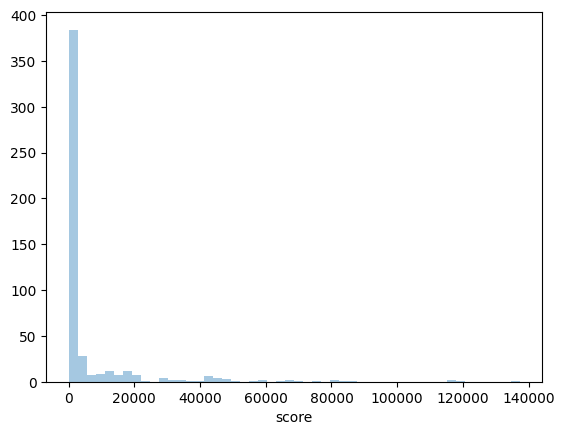

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
df_reduced = df_joined[['ACCESSION_NUMBER','TRX_TEST_SCORE','GT']]
df_reduced.columns = ['id','score','GT']
sns.distplot(df_reduced['score'],kde=False)

(Organizamos así el diccionario porque las funciones son mas flexibles, permiten trabajar con mas de una opcion de fuente de datos, de score, etc):

In [21]:
datasets = {}

datasets['hospital'] = {}

datasets['hospital']['targets'] = df_reduced.GT.values

# Tipos de priors (en este caso son iguales):
datasets['hospital']['prior_of_data'] = df_reduced.GT.value_counts(normalize=True)[1] # prior+

"""Como el set fue tomado prospectivo del ambito real de aplicacion, podemos utilizar 
la prior del set (es decir, % de clase positiva en el GT), como estimacion de prior_real:"""
datasets['hospital']['prior_real'] = datasets['hospital']['prior_of_data'] 

# Usos para las priors (pueden variarse):
datasets['hospital']['weight_prior'] = datasets['hospital']['prior_of_data'] 
datasets['hospital']['prior_for_LLRposterior_change'] = datasets['hospital']['prior_real']

datasets['hospital']['score'] = {}

""" Consideramos el score como likelihood ratio en vez de posterior, dado que su rango no es [0,1].
Es decir, el log likelihood ratio (LLR) es el log del score del effusion-detector"""
datasets['hospital']['score']['LLR'] = np.log(df_reduced.score.values + np.finfo(float).eps)

"""Luego, calculamos lo que serían nuestras posteriors (seguramente muy descalibradas, es decir, 
seguramente no representan una probabilidad de pertenencia a clase positiva). Las calculamos con los LLR 
pero incorporandole la prior real"""
datasets['hospital']['score']['posteriors'] = expit(datasets['hospital']['score']['LLR'] + logit(datasets['hospital']['prior_of_data']))


# Calibración

## Entreno calibrador con una porción de los datos y lo evalúo en los datos restantes

Con una parte de los datos (test_size) ajustamos una regresion lineal minimizando una weighted cross-entropy, que usa como pesos las priors "weight_prior". La cross entropy comun, sin weights, equivale a considerar como prior el balance de clase en los datos de ajuste. Notese que en este caso particular seria lo mismo que usar la cross-entropy comun, porque el valor de "weight_prior" se calculo como la prior de los datos. 

Para ver si nuestros scores estaban descalibrados, comparamos el delta de cross-entropy medido en la porcion restante de datos (test) antes y despues de calibrar. 

In [22]:
calibrate_and_test('hospital', datasets, scores_options=['score'], test_size=0.5)

n0= 437 . n1= 69 

-------
SCORE
AUC full data: 0.9542
Original CE in test: 1.6059. 
Calibrated CE in test: 0.1977
DeltaEPSR in test=87.6920%
Regression parameters: [0.9909, -7.5831]



En el ejemplo simulado, el cross-entropy mejoró en un 94% al calibrar, indicando que los scores están más calibrados luego de transformarlos con la regresión. Esta transformación es sencillamente aplicar combinacion lineal de los regression parameters sobre los LLRs

## Ploteo los LLRs antes y después de calibrar

<module 'matplotlib.pyplot' from 'd:\\ProgramData\\miniconda3\\envs\\derrame_trx\\lib\\site-packages\\matplotlib\\pyplot.py'>

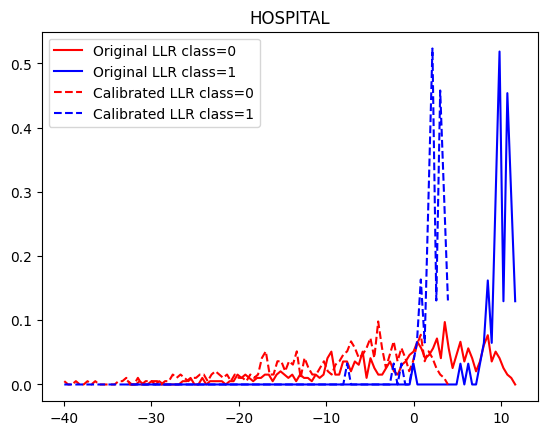

In [23]:
plot_bef_after('hospital', 'score', datasets, 'LLR')

En el ejemplo simulado, vemos como los histogramas linea punteada son una transformacion de los histogramas linea continua, y se han transformado de forma que el umbral de menor costo (con el que nos quedan mejor separadas las áreas) se desplaza

## Ploteo las posteriors antes y después de calibrar

<module 'matplotlib.pyplot' from 'd:\\ProgramData\\miniconda3\\envs\\derrame_trx\\lib\\site-packages\\matplotlib\\pyplot.py'>

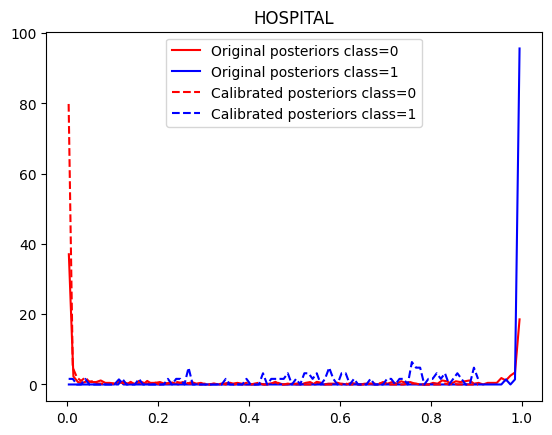

In [24]:
plot_bef_after('hospital', 'score', datasets, 'posteriors')

## Cálculo de NEC y umbrales óptimos

Para calcular el costo esperado (EC) y el costo esperado normalizado (NEC), es necesario definir la prior que esperamos encontrar en la aplicación real (real_prior) y la matriz de costos (definir qué costo es más grave: falso positivo y falso negativo, y en qué medida)

In [25]:
real_prior = datasets['hospital']['prior_real'] # Como definimos arriba, en este caso nuestra prior de datos coincide con la prior real

COST_FALSE_NEGATIVE = 1 # Un falso positivo es x veces más costoso que un falso negativo. Aqui simulamos que el falso positivo es mas costoso

cost_matrix = [[0,1],[COST_FALSE_NEGATIVE,0]]

ANTES DE CALIBRAR:

Min EC: 0.0751 
Min NEC: 0.5507 
 Min th (best th)=9.3702
Bayes LLR th=1.8458
Bayes EC=0.3794
Bayes NEC=2.7826


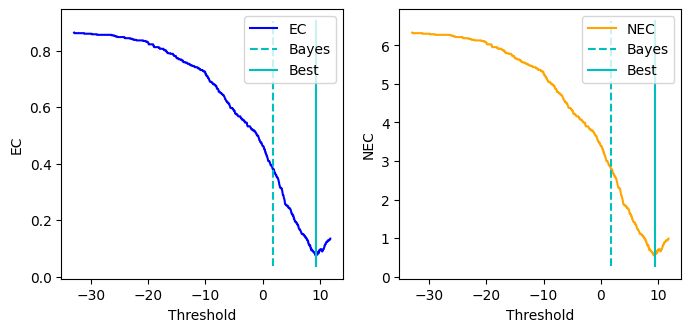

In [26]:
add_EC('hospital', 'score', datasets, real_prior,  cost_matrix=cost_matrix)
plot_cost_and_thrs('hospital', 'score', datasets, real_prior,  cost_matrix=cost_matrix)

Los graficos de costo nos muestran el valor del EC (azul) y del NEC (amarillo) a medida que barremos los posibles umbrales sobre los LLRs (eje horizontal). Notar que el EC y el NEC son proporcionales (curvas iguales) pero el rango del NEC es interpretable. Todos los umbrales donde el NEC>1 significa que hubiesemos tomado mejores decisiones eligiendo en base a la prior sin prestar atención al output del modelo.

En el ejemplo simulado, vemos que el umbral que minimiza los costos es para LLR=9.5491

En el ejemplo simulado, vemos que el umbral de Bayes no cae exactamente en LLR=0 (que corresponderia a umbralizar en posteriors=0.5). Esto es porque el prior de clase positiva no es 50% y porque los errores no tienen igual costo. 

Ejercicio: probar como cambiar el ratio de costos y la prior esperada cambian el valor de Bayes LLR th, y como cambian las curvas de costos

 DESPUÉS DE CALIBRAR

Min EC: 0.0751 
Min NEC: 0.5507 
 Min th (best th)=1.7021
Bayes LLR th=1.8458
Bayes EC=0.0810
Bayes NEC=0.5942


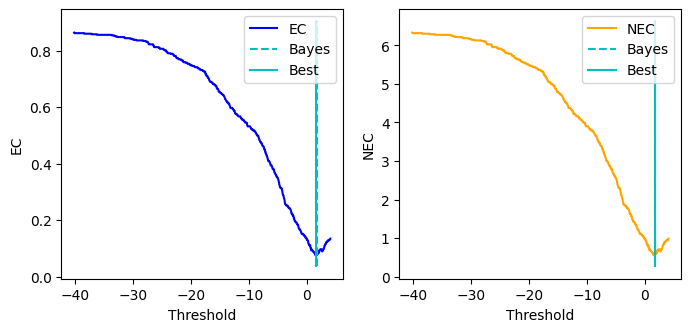

In [27]:
add_EC('hospital', 'score', datasets, real_prior,  cost_matrix=cost_matrix,use_calib=True)
plot_cost_and_thrs('hospital', 'score', datasets, real_prior,  cost_matrix=cost_matrix)

La calibración hace que el umbral de Bayes pase a coincidir con el umbral de menor costo esperado

Y este umbral de Bayes en LLR, a qué se correspondería en el mundo de probabilidades posterior? Es necesario aplicar la inversa para encontrar la equivalencia del umbral de Bayes en las posteriors:

In [28]:
bayes_th_as_posterior = expit(datasets['hospital']['score']['bayes_thr_for_EC'] + logit(datasets['hospital']['prior_for_LLRposterior_change']))
best_th_as_posterior = expit(datasets['hospital']['score']['best_thr_for_EC'] + logit(datasets['hospital']['prior_for_LLRposterior_change']))
print(f'Best th in calibrated posteriors domain {best_th_as_posterior}')
print(f'Bayes th in calibrated posteriors domain {bayes_th_as_posterior}')

Best th in calibrated posteriors domain 0.46412838201445783
Bayes th in calibrated posteriors domain 0.5


El umbral de Bayes es el mejor teorico para cuando los LLRs estan calibrados. Entonces tenemos dos opciones:

- Calibramos los LLRs usando los parametros de la regresion lineal que ajustamos, y aplicamos el umbral de Bayes sobre esos LLR para así tener decisiones binarias
- Trasladamos el umbral de Bayes al mundo de los LLRs descalibrados. Es decir, le aplicamos la inversa de la regresión lineal que ajustamos. Este nuevo Bayes des-transformado lo podemos aplicar directamente sobre los LLRs crudos sin calibrar, y así tener decisiones binarias


Busquemos entonces ese umbral de Bayes des-transformado:

In [29]:
bayes_th_as_LR = np.exp(datasets['hospital']['score']['bayes_thr_for_EC']) 
best_th_as_LR = np.exp(datasets['hospital']['score']['best_thr_for_EC'])
print(f'Best th in calibrated posteriors domain {best_th_as_LR}')
print(f'Bayes th in calibrated posteriors domain {bayes_th_as_LR}')

Best th in calibrated posteriors domain 5.485417876409235
Bayes th in calibrated posteriors domain 6.333333333333334


In [30]:
regression_parameters =  datasets['hospital']['after_cal']['score']['conf']['reg_parameters']
#calibrated_LLRs = parameters[0] * scores + parameters[1]
bayes_th_as_LR_raw = np.exp((datasets['hospital']['score']['bayes_thr_for_EC']-regression_parameters[1])/regression_parameters[0])#  + logit(datasets['hospital']['prior_for_LLRposterior_change']))
best_th_as_LR_raw = np.exp((datasets['hospital']['score']['best_thr_for_EC']-regression_parameters[1])/regression_parameters[0]) # + logit(datasets['hospital']['prior_for_LLRposterior_change']))
print(f'Best th in uncalibrated LR domain {bayes_th_as_LR_raw}')
print(f'Bayes th in uncalibrated LR domain {best_th_as_LR_raw}')

Best th in uncalibrated LR domain 13565.058680614336
Bayes th in uncalibrated LR domain 11733.497955415432


# Evaluación de umbral

Vamos a ver cual era el desempeño del umbral de Bayes (umbral teórico) si no hubieramos calibrado, y como cambia el desempeño si aplicamos ese mismo umbral pero en los scores calibrados (i.e., transformados con la regresion lineal)

In [31]:
binarize_scores('hospital', 'score', datasets,th_type='bayes') #Binarize with Bayes on uncalibrated scores
print('\nBAYES CLASSIFICATION PERFORMANCE WITHOUT CALIBRATION')
add_classification_metrics('hospital', 'score', datasets,th_type='bayes',
                           positive_prior=real_prior,  cost_matrix=cost_matrix)
print('\n\nBAYES CLASSIFICATION PERFORMANCE WITH CALIBRATION')
add_classification_metrics('hospital', 'score', datasets,th_type='bayes', use_calib=True,
                           positive_prior=real_prior,  cost_matrix=cost_matrix) # with Bayes on calibrated scores


bayes th is LLR=1.8458 LR=6.3333

BAYES CLASSIFICATION PERFORMANCE WITHOUT CALIBRATION
Classification metrics:
binary_CE: 13.1059
binary_roc_auc: 0.7742
binary_pr_auc: 0.6250
accuracy: 0.6206
precision: 0.2625
recall: 0.9855
f1: 0.4146
EC: 0.3794
NEC: 2.7826
specificity: 0.5629
vpn: 0.9960


BAYES CLASSIFICATION PERFORMANCE WITH CALIBRATION
Classification metrics:
binary_CE: 2.7986
binary_roc_auc: 0.8249
binary_pr_auc: 0.7215
accuracy: 0.9190
precision: 0.7059
recall: 0.6957
f1: 0.7007
EC: 0.0810
NEC: 0.5942
specificity: 0.9542
vpn: 0.9521


Con el ejemplo simulado, vemos que el umbral de Bayes en los scores crudos tenia una sensibilidad perfecta (recall=1) pero muy mala precision (0.32). Es decir, muchos falsos positivos.

En cambio, el umbral de Bayes en los scores calibrados presenta una precision muy alta 0.91, a costa de menor recall. Esto es porque indicamos que un falso positivo era mas costoso incluso que un falso negativo, por lo que el umbral de Bayes va a minimizar teniendo eso en cuenta. 

Para el análisis con datos del etiquetado real, lo importante es comparar si disminuye el cross-entropy y el NEC, que son los proper scoring rules

### Umbral actual (3440.5)

Evaluamos el desempeño en este subset del umbral actual de TRx, que es ICT=0.5

In [32]:
current_th = 3440.5
current_metrics = print_classification_metrics(df_reduced.GT.values, df_reduced.score.values > current_th, 
                                       positive_prior= real_prior, cost_matrix=cost_matrix)

Classification metrics:
binary_CE: 3.8226
binary_roc_auc: 0.9054
binary_pr_auc: 0.7470
accuracy: 0.8893
precision: 0.5565
recall: 0.9275
f1: 0.6957
EC: 0.1107
NEC: 0.8116
specificity: 0.8833
vpn: 0.9872


In [33]:
LLR_th_equivalent = np.log(current_th  + np.finfo(float).eps) - logit(real_prior)    
LLR_th_equivalent

9.989198779140866

Ahora evaluémos nuestro umbral de Bayes trasladado directamente sobre los scores

In [34]:
bayes_metrics = print_classification_metrics(df_reduced.GT.values, 
                                             df_reduced.score.values > bayes_th_as_LR_raw, 
                                       positive_prior=real_prior, cost_matrix=cost_matrix)

Classification metrics:
binary_CE: 2.7986
binary_roc_auc: 0.8249
binary_pr_auc: 0.7215
accuracy: 0.9190
precision: 0.7059
recall: 0.6957
f1: 0.7007
EC: 0.0810
NEC: 0.5942
specificity: 0.9542
vpn: 0.9521


In [35]:
df_comparacion = pd.DataFrame([current_metrics, bayes_metrics])
df_comparacion.index=[f'th={current_th:.2f}',f'th={bayes_th_as_LR_raw:.2f}']
df_comparacion = df_comparacion[['binary_CE','EC','NEC','binary_roc_auc','binary_pr_auc','accuracy','recall','specificity','precision','vpn','f1']]
df_comparacion.columns = ['Entropía cruzada','Costo esperado', 'Costo esperado normalizado','AUC-ROC binario','AUC-PR binario','Exactitud','Sensibilidad',
                          'Especificidad','VPP o precisión','VPN','F1-score']
df_comparacion.round(4).T

,th=3440.50,th=13565.06
Entropía cruzada,3.8226,2.7986
Costo esperado,0.1107,0.0810
Costo esperado normalizado,0.8116,0.5942
AUC-ROC binario,0.9054,0.8249
AUC-PR binario,0.7470,0.7215
Exactitud,0.8893,0.9190
Sensibilidad,0.9275,0.6957
Especificidad,0.8833,0.9542
VPP o precisión,0.5565,0.7059
VPN,0.9872,0.9521


Es importante detenerse a analizar las métricas. 

No quedarse on el mejor ROC_AUC. Esta métrica es insensible al desbalance: sería un mejor modelo si la prevalencia de derrame fuera de 50%. Dado que no es el caso, toman relevancia métricas como la PR_AUC, precisión o f1 score. Igualmente, estas métricas también tienen limitaciones (ver paper de Luciana!). La métrica más valiosa cuando contamos con la prevalencia y con la matriz de costos es el NEC, así que comparar esa métrica a ver que umbral tiene menor NEC.

Como pendiente, quedaría evaluar si la diferencia de NECs es significativa con bootstrap o algún test estadístico. 